In [1]:
from fastai.vision.all import *
import albumentations
from random import randint
import glob
# import plotly.express as px 

plt.style.use("dark_background")

#### Environnement :
<br> Python : 3.7
<br>pip3 install albumentations 
<br>pip3 install torch==1.8.2 torchvision==0.9.2 torchaudio==0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111 
<br>pip3 install fastai 


In [2]:
# Travailler avec le GPU
torch.cuda.empty_cache()
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True


In [3]:
train_dir = "pic_MO_100_300_resized\\train"  
# Dossier contenant les images. Le dossier doit contenir un sous-dossier par label. Avec nom label == nom sous-dossier

In [4]:
# Compte le nombre de label ainsi que le nombre d'image par label.
path_cat = glob.glob(train_dir+"\\*")
nbr_cat = len(path_cat)
cat_name = []
nbr_image_cat = []
for path in path_cat:
    cat_name.append(path.split('\\')[-1])
    imgs = glob.glob(path+"\\*")
    nbr_image_cat.append(len(imgs)) 
    
print('Nombre de catégories :',nbr_cat)
print("Nombre total d'images :",sum(nbr_image_cat))
print("La catégorie avec le moins d'images a :",min(nbr_image_cat),"images")
print("La catégorie avec le plus d'images a :",max(nbr_image_cat),"images")
print("En moyenne on a :",np.mean(nbr_image_cat),"images par catégorie")

Nombre de catégories : 100
Nombre total d'images : 26601
La catégorie avec le moins d'images a : 224 images
La catégorie avec le plus d'images a : 310 images
En moyenne on a : 266.01 images par catégorie


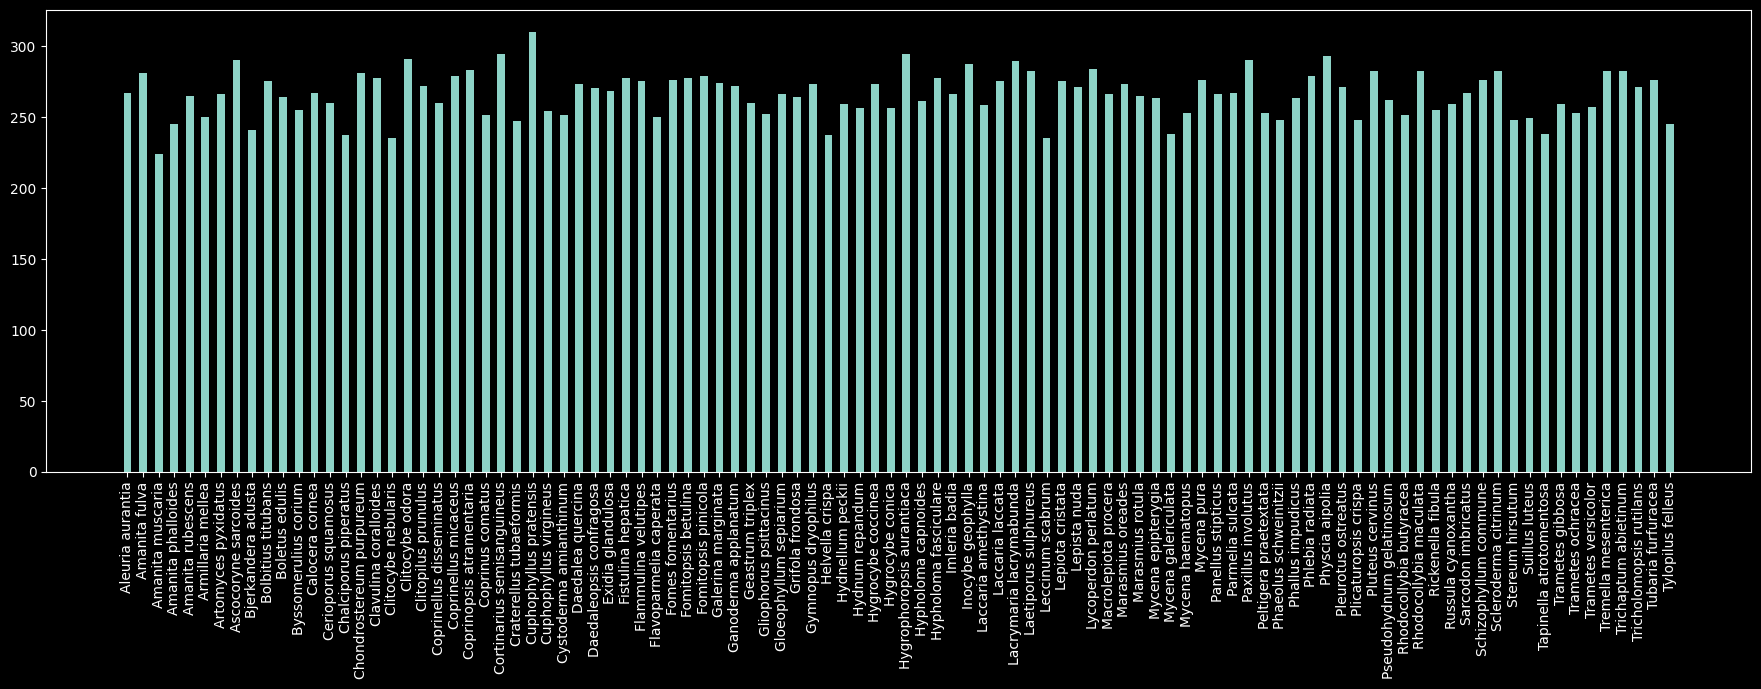

In [5]:
# Bar plot du nombre d'images par label.
plt.figure(figsize=(22,6))
plt.bar(cat_name,nbr_image_cat,width=0.5)
plt.xticks(rotation=90);

Chargement des données

In [6]:
bs = 50 # Batch_size, il faut essayer de travailler avec le plus grand batch_size possible. NB : Diminuer le batch_size est une méthode de régularisation.
prop_image = 1 # Proportion d'images que l'on veut utiliser. On peut prendre moins d'images pour que le modèle tourne plus vite. NB : Moins on a d'images + on overfit.
valid_pct = 0.15 # Proportion d'images pour le jeu de validation.

In [7]:
# Data augmentation. On utilise la bibliothèque albumentations.  NB : Data augmentation = réduire l'overfitting
def get_train_aug(): return albumentations.Compose([
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            albumentations.RandomBrightnessContrast(p=0.5),
            albumentations.CoarseDropout(p=0.5),
])


class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [8]:
item_tfms = [Resize(224),AlbumentationsTransform(get_train_aug())]

In [9]:
def custom_splitter(pct_tot,valid_pct):
    def fn(fnames):
        train_idx, valid_idx = RandomSplitter(valid_pct=valid_pct,seed=42)(fnames)
        np.random.shuffle(train_idx)
        np.random.shuffle(valid_idx)
        train_len = int(len(train_idx) * pct_tot)
        valid_en = int(len(valid_idx) * pct_tot)
        return train_idx[0:train_len], valid_idx[0:valid_en]
    return fn

In [10]:
# Chargement des images via l'objet DataBlock de fastai.
dls = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y     = parent_label,
                splitter  = custom_splitter(pct_tot = prop_image,valid_pct = valid_pct),
                item_tfms=item_tfms).dataloaders(train_dir,bs=bs,verbose=True)

Found 26601 items
2 datasets of sizes 22611,3990
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> AlbumentationsTransform -- {'train_aug': Compose([
  Transpose(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
  RGBShift(always_apply=False, p=0.5, r_shift_limit=(-15, 15), g_shift_limit

Observation des données

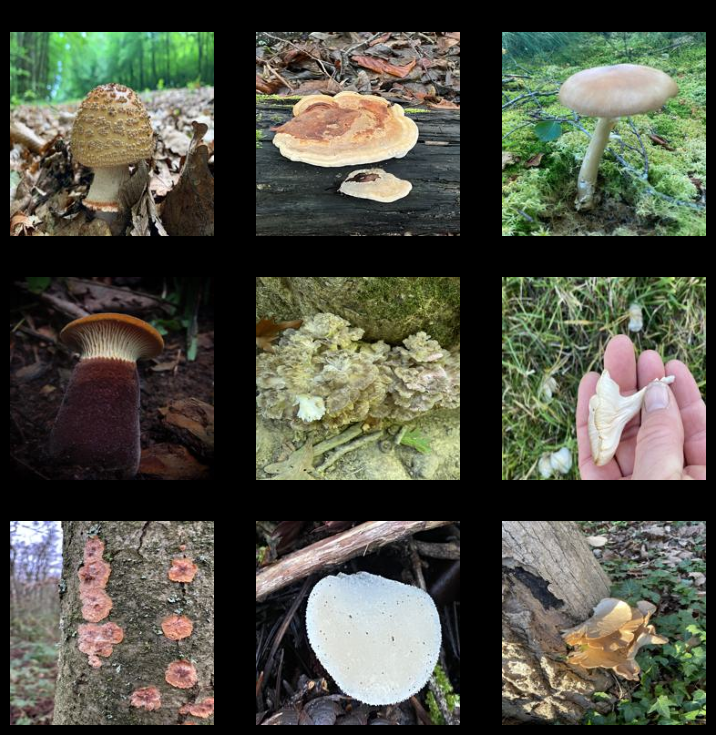

In [20]:
# Données de validation (sans augmentation)
dls.valid.show_batch()

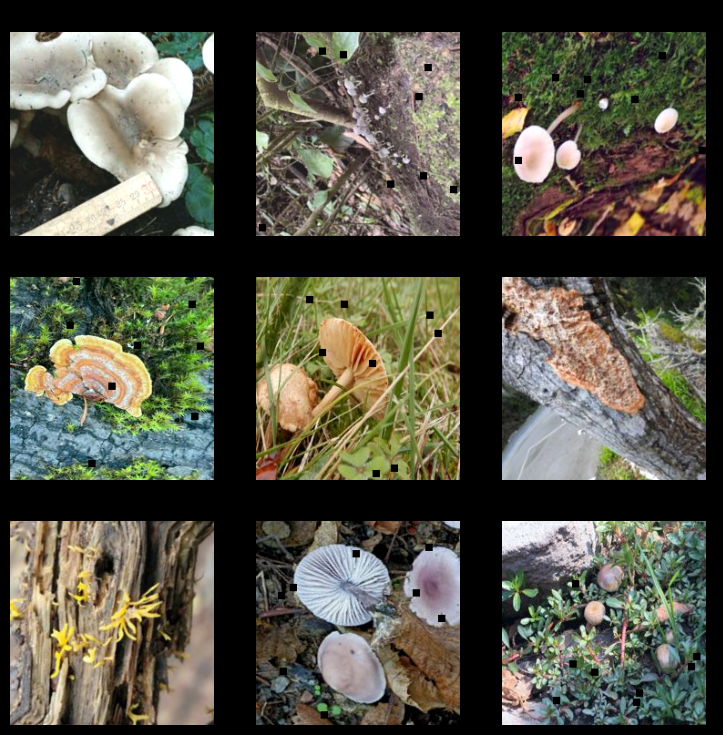

In [21]:
# Données d'entraînement (avec augmentation)
dls.train.show_batch()

In [11]:
 #Achitecture classificateur
Denses = [1024]
Batch_norm = True
drops_out = [0.25,0.5]
concat_pool = True
premodel = densenet161()
premodel2 = densenet161

# Paramètres d'entraînement. On fait du transfer learning, on va d'abord entraîner le classificateur (rough) puis on va unfreeze les couches convolutionnelles pours le entraîner (fine)
#Les lr ont été estimé grâce à la fonction lr_find cf plus bas
wd = 1e-8
lr_rough = 0.1
lr_fine = 0.01
epoch_rough = 100
epoch_fine = 30

In [14]:
body = create_body(premodel,cut=-1)
nbr_features = num_features_model(nn.Sequential(*body.children()))
del body

In [15]:
Classificateur = create_head(nbr_features,dls.c,lin_ftrs=Denses,first_bn=Batch_norm,bn_final=False,ps = drops_out,concat_pool=True)

In [16]:
# Créations du modèle grâce à la fonction vision_learner de fastai. fastai créer un classifaicateur qui va bien ;) En particulier on peut noter la présence de de pooling après la partie
# convo. Un max et un avg qui soint ensuite concatennés. Le classificateur comporte une couche de 512 neuronnes.
learn = vision_learner(dls,premodel2,custom_head=Classificateur,metrics=[accuracy],opt_func = partial(SGD,wd=wd),pretrained=True).to_fp16()
model_name = "densenet161_100300cat_SGD_fitoc30_wd=1e-6_lr=0.1"

learn.to(device)
learn.summary()

Output()

Sequential (Input shape: 50 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     50 x 96 x 112 x 112 
Conv2d                                    14112      True      
BatchNorm2d                               192        True      
ReLU                                                           
____________________________________________________________________________
                     50 x 96 x 56 x 56   
MaxPool2d                                                      
BatchNorm2d                               192        True      
ReLU                                                           
____________________________________________________________________________
                     50 x 192 x 56 x 56  
Conv2d                                    18432      True      
BatchNorm2d                               384        True      
ReLU                                                           
___________________________________

Output()

0.015848932787775993

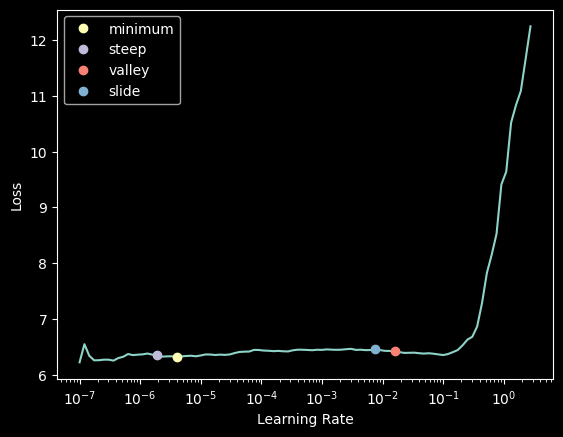

In [26]:
# La fonction lr_find de fastai permet de déterminer le meilleur learning rate (hyperparam le plus important). Dans la litérature on trouve deux points intéressants : valley et steep
sr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
sr.valley

In [17]:
# Fit avec la méthode fit_one_cycle. fit avec lr qui varie de lr_max/25 à lr_max puis à lr_max/100000. cf Leslie SMith paper
# Callback SaveModelCallback permet de sauvegarder le meilleur modèle
# Callback CSVLogger permet de sauvegarder en format csv les loss, validation loss et validation accuracy
learn.fit_one_cycle(epoch_rough,lr_max=lr_rough,cbs=[SaveModelCallback(monitor='accuracy',fname='model_{0}'.format(model_name),comp=np.greater,reset_on_fit=True,with_opt=True),
                                     CSVLogger(fname='history_{0}_rough.csv'.format(model_name), append=False)])

Output()

Better model found at epoch 0 with accuracy value: 0.05463659018278122.


Better model found at epoch 1 with accuracy value: 0.07268170267343521.


Better model found at epoch 2 with accuracy value: 0.09624060243368149.


Better model found at epoch 3 with accuracy value: 0.10977443307638168.


Better model found at epoch 5 with accuracy value: 0.137092724442482.


Better model found at epoch 6 with accuracy value: 0.14360901713371277.


Better model found at epoch 9 with accuracy value: 0.1463659107685089.


Better model found at epoch 12 with accuracy value: 0.17067669332027435.


Better model found at epoch 14 with accuracy value: 0.17969924211502075.


Better model found at epoch 15 with accuracy value: 0.2007518857717514.


Better model found at epoch 16 with accuracy value: 0.206516295671463.


Better model found at epoch 17 with accuracy value: 0.2348370999097824.


Better model found at epoch 19 with accuracy value: 0.24335838854312897.


Better model found at epoch 21 with accuracy value: 0.28621554374694824.


Better model found at epoch 22 with accuracy value: 0.3263157904148102.


Better model found at epoch 23 with accuracy value: 0.3380952477455139.


Better model found at epoch 25 with accuracy value: 0.3583959937095642.


Better model found at epoch 27 with accuracy value: 0.39047619700431824.


Better model found at epoch 31 with accuracy value: 0.42807018756866455.


Better model found at epoch 32 with accuracy value: 0.4353383481502533.


Better model found at epoch 36 with accuracy value: 0.45989975333213806.


Better model found at epoch 42 with accuracy value: 0.4909774363040924.


Better model found at epoch 43 with accuracy value: 0.49949875473976135.


Better model found at epoch 46 with accuracy value: 0.5290727019309998.


Better model found at epoch 55 with accuracy value: 0.5604010224342346.


Better model found at epoch 58 with accuracy value: 0.5799498558044434.


Better model found at epoch 63 with accuracy value: 0.5817042589187622.


Better model found at epoch 64 with accuracy value: 0.5979949831962585.


Better model found at epoch 65 with accuracy value: 0.5994987487792969.


Better model found at epoch 68 with accuracy value: 0.6047618985176086.


Better model found at epoch 70 with accuracy value: 0.6065163016319275.


Better model found at epoch 71 with accuracy value: 0.617042601108551.


Better model found at epoch 75 with accuracy value: 0.6200501322746277.


Better model found at epoch 77 with accuracy value: 0.6258145570755005.


Better model found at epoch 78 with accuracy value: 0.6270676851272583.


Better model found at epoch 81 with accuracy value: 0.6360902190208435.


Better model found at epoch 84 with accuracy value: 0.6368421316146851.


Better model found at epoch 86 with accuracy value: 0.6385964751243591.


Better model found at epoch 87 with accuracy value: 0.6398496031761169.


Better model found at epoch 89 with accuracy value: 0.640852153301239.


Better model found at epoch 91 with accuracy value: 0.6451127529144287.


Better model found at epoch 93 with accuracy value: 0.6456140279769897.


Better model found at epoch 95 with accuracy value: 0.6473684310913086.


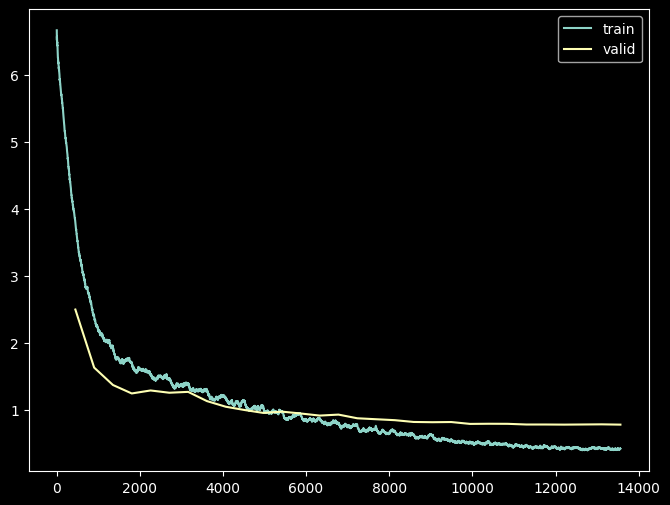

In [15]:
# On trace les Loss.
plt.rcParams["figure.figsize"] = (8,6)
learn.recorder.plot_loss()

In [16]:
#On load le meilleur modèle précédent, puis on unfreeze toute les layers.
learn.load('model_{0}'.format(model_name))
learn.unfreeze()

Output()

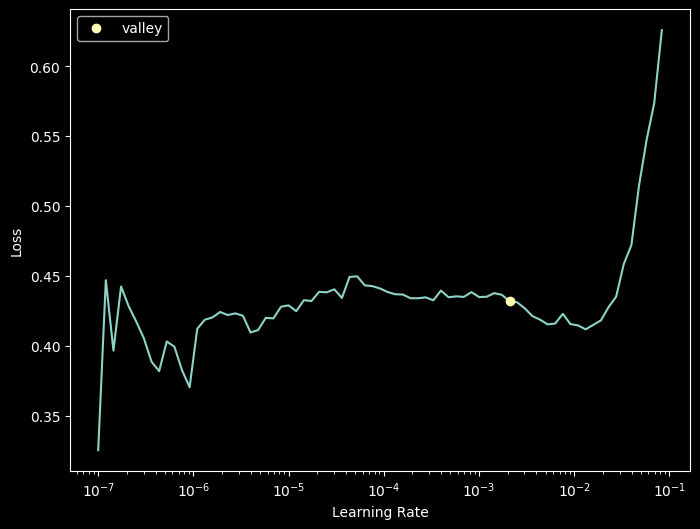

In [17]:
sr = learn.lr_find()

In [18]:
# Fit avec la méthode fit_one_cycle. On divise le lr_max par environ 10
learn.fit_one_cycle(epoch_fine,lr_max=lr_fine,cbs=[SaveModelCallback(monitor='accuracy',fname='modelf_{0}'.format(model_name),comp=np.greater,reset_on_fit=True,with_opt=True),
                                     CSVLogger(fname='history_{0}_fine.csv'.format(model_name), append=False)])

Output()

Better model found at epoch 0 with accuracy value: 0.7864661812782288.


Better model found at epoch 1 with accuracy value: 0.7867168188095093.


Better model found at epoch 13 with accuracy value: 0.7879699468612671.


Better model found at epoch 14 with accuracy value: 0.7907268404960632.


Better model found at epoch 17 with accuracy value: 0.7984962463378906.


Better model found at epoch 19 with accuracy value: 0.7989975214004517.


Better model found at epoch 20 with accuracy value: 0.8047618865966797.


Better model found at epoch 21 with accuracy value: 0.8082706928253174.


Better model found at epoch 23 with accuracy value: 0.8120300769805908.


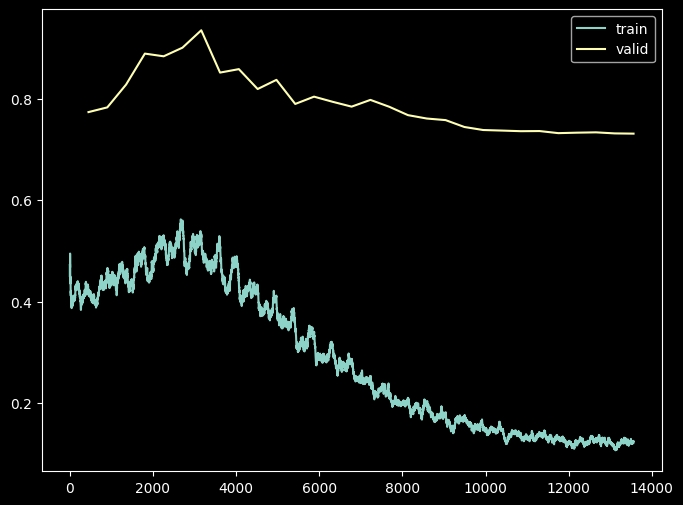

In [19]:
# plot les loss
plt.rcParams["figure.figsize"] = (8,6)
learn.recorder.plot_loss()

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

Output()

True

Output()

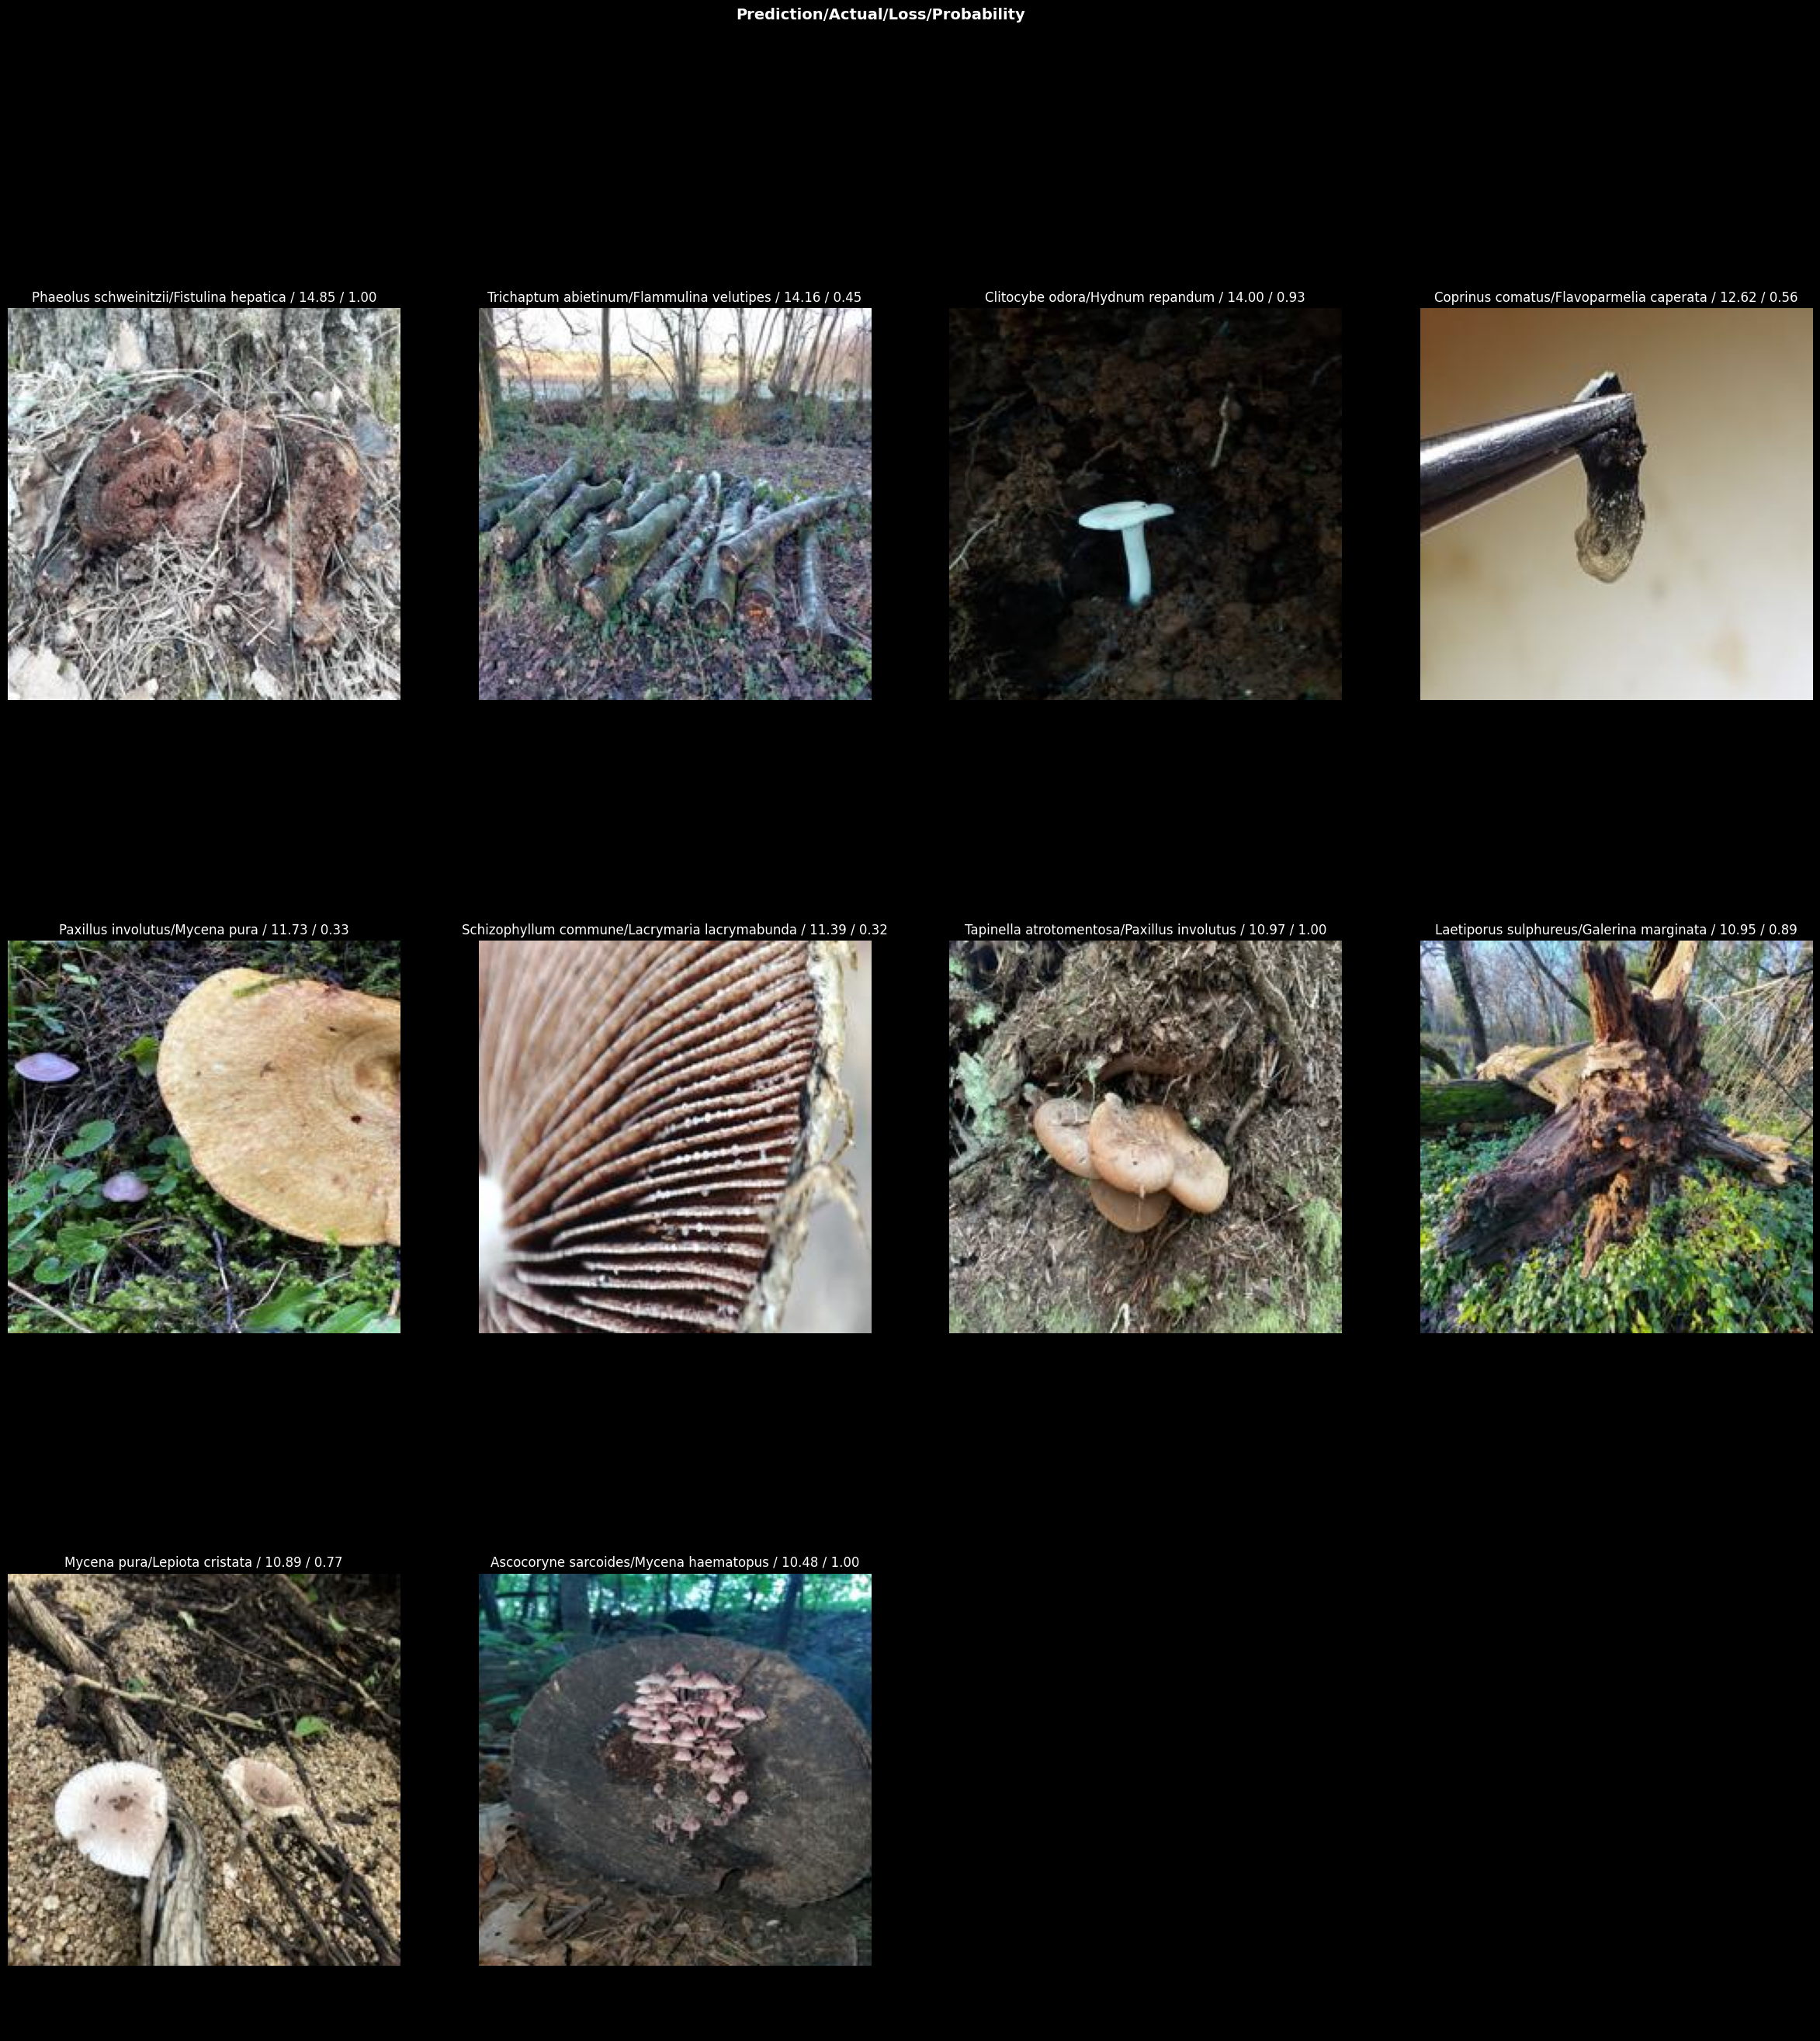

In [21]:
interp.plot_top_losses(10, figsize=(30,30),largest=True)

In [22]:
interp.print_classification_report()

Output()

                            precision    recall  f1-score   support

          Aleuria aurantia       0.91      0.97      0.94        31
             Amanita fulva       0.83      0.81      0.82        37
          Amanita muscaria       0.90      0.90      0.90        30
        Amanita phalloides       0.73      0.78      0.75        49
         Amanita rubescens       0.86      0.90      0.88        40
         Armillaria mellea       0.86      0.66      0.75        38
       Artomyces pyxidatus       0.97      0.91      0.94        35
      Ascocoryne sarcoides       0.88      0.88      0.88        52
        Bjerkandera adusta       0.61      0.65      0.62        31
        Bolbitius titubans       0.98      0.93      0.95        43
            Boletus edulis       0.81      0.63      0.71        41
      Byssomerulius corium       0.92      0.94      0.93        35
           Calocera cornea       0.97      0.97      0.97        38
      Cerioporus squamosus       0.82      0.89

In [23]:
interp.most_confused()

Output()

[('Inocybe geophylla', 'Mycena pura', 12),
 ('Ganoderma applanatum', 'Fomes fomentarius', 6),
 ('Rhodocollybia butyracea', 'Gymnopus dryophilus', 5),
 ('Trametes versicolor', 'Trametes gibbosa', 5),
 ('Clitocybe nebularis', 'Clitopilus prunulus', 4),
 ('Clitocybe odora', 'Clitopilus prunulus', 4),
 ('Clitopilus prunulus', 'Clitocybe odora', 4),
 ('Coprinellus disseminatus', 'Coprinellus micaceus', 4),
 ('Coprinellus micaceus', 'Coprinopsis atramentaria', 4),
 ('Fomitopsis pinicola', 'Fomes fomentarius', 4),
 ('Pluteus cervinus', 'Rhodocollybia butyracea', 4),
 ('Trametes versicolor', 'Bjerkandera adusta', 4),
 ('Trichaptum abietinum', 'Trametes gibbosa', 4),
 ('Bjerkandera adusta', 'Chondrostereum purpureum', 3),
 ('Boletus edulis', 'Amanita phalloides', 3),
 ('Boletus edulis', 'Tylopilus felleus', 3),
 ('Coprinellus disseminatus', 'Marasmius rotula', 3),
 ('Flammulina velutipes', 'Galerina marginata', 3),
 ('Fomitopsis betulina', 'Fomes fomentarius', 3),
 ('Galerina marginata', 'Flamm

In [ ]:
#On peut ensuite exporter le modèle. On testera le modèle sur un jeu de donnée test dans un autre notebook
# Remarque : Pour charger le modèle dans un autre notebook, il faut aussi charger les fonctions,qui ne sont pas dans fastai, utilisées. Ici c'est la fonction de dataaugment avec la biblio 
# albumentations. (Même si on a pas besoin de la data augmentation pour les prédictions, il faut quand même la charger)
learn.export('name_model.pkl')